# Packages and Functions

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from pytope import Polytope                        # only for plots
from functions import functions_IABVG as my
import time
from itertools import product

# Configurations

In [4]:
cfg = {}
cfg["Households"] = 2                               # number of household batteris
cfg["Time periods"] = 2                             # number of time periods
cfg["dt"] = 1/4                                     # step size
cfg["Numb Cost Vectors"] = 1
cfg["path HH"] = "data/processed_hh/"               # data path household demand
cfg["path DA"] = "data/processed_da/"               # data path prices
cfg["Random Seed"] = 95                             # Ranodm Seed
cfg["Opt Type"] = 1                                 # (0) min cost, (1) min peak
cfg["G"] = cfg["Time periods"]*cfg["Time periods"]  # number of signal vectors in {-1,1}^d (adjusts accuracy and computation time)

# Data

In [8]:
c_list,D = my.importData(cfg)
c = c_list[0]
D_aggr = np.sum(D,axis=0)
batts = my.createRandomBatteryValues(cfg)
A_list,b_list = my.get_Ab(cfg,batts)

# Computations

In [9]:
#np.random.seed(cfg["Random Seed"]) # set random seed

t0 = time.process_time() # start time
# create siganl vectors in {-1,1}^d
if cfg["Time periods"] > 8:
    arr = my.random_signals(cfg["Time periods"],cfg["G"])
else:
    arr = list(product([0, 1], repeat=cfg["Time periods"]))

# calculate approximation
vertices = my.get_vertices(batts["S_0"][0],batts["S_max"][0],batts["S_min"][0],batts["x_max"][0],batts["x_min"][0],batts["alpha"][0],batts["S_f"][0],cfg,arr)
for i in range(1,cfg["Households"]):
    vertices += my.get_vertices(batts["S_0"][i],batts["S_max"][i],batts["S_min"][i],batts["x_max"][i],batts["x_min"][i],batts["alpha"][i],batts["S_f"][i],cfg,arr)
if cfg["Time periods"] > 8:
    vertices = np.concatenate((vertices,np.zeros([cfg["Time periods"],1])),axis=1) # add vector of zeros if cfg["G"] < 2^d
print(f"time taken: {time.process_time() - t0} s") # stop time

# calculate UPR values
sol, sol_exact = my.costPeakReduction(A_list,b_list,vertices,D,c,cfg["dt"],cfg["Time periods"],cfg["Households"],cfg["Opt Type"]) 
if cfg["Opt Type"] == 0:
    UPR = 100*(c@(sol + D_aggr) - c@(sol_exact + D_aggr))/(c@D_aggr - c@(sol_exact + D_aggr))
    print(f"Cost UPR: {UPR:.2f} %")
elif cfg["Opt Type"] == 1:
    UPR = 100*(np.linalg.norm(sol + D_aggr, np.inf) - np.linalg.norm(sol_exact + D_aggr, np.inf))/(np.linalg.norm(D_aggr, np.inf) - np.linalg.norm(sol_exact + D_aggr, np.inf))
    print(f"Peak Power UPR: {UPR:.2f} %")

time taken: 0.00036452099999984 s
Peak Power UPR: -0.00 %


# Figures

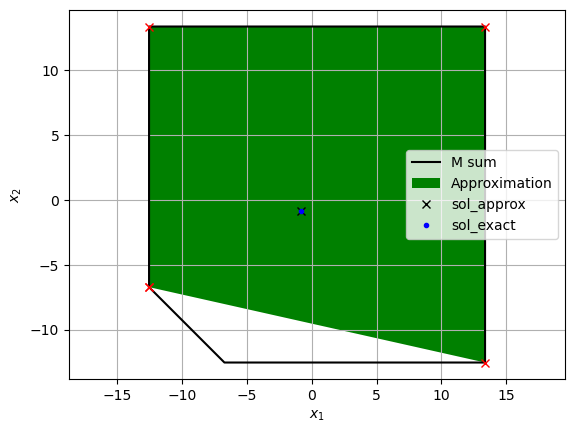

In [10]:
if cfg["Time periods"] == 2:
    P = Polytope(A_list[0],b_list[0])
    for i in range(1,cfg["Households"]):
        P = P + Polytope(A_list[i],b_list[i])
        
    V = P.V_sorted()
    x_list = [item[0] for item in V]
    x_list.append(V[0][0])
    y_list = [item[1] for item in V]
    y_list.append(V[0][1])
    plt.plot(x_list,y_list,"k",label="M sum")
    plt.axis('equal')
    
    P = Polytope(vertices.T)
    P.minimize_V_rep()
    V = P.V_sorted()
    x_list = [item[0] for item in V]
    x_list.append(V[0][0])
    y_list = [item[1] for item in V]
    y_list.append(V[0][1])
    plt.fill(x_list,y_list,"g",label="Approximation")
    plt.plot(x_list,y_list, "rx")
    plt.plot(sol[0],sol[1],"x",color="black",label="sol_approx")
    plt.plot(sol_exact[0],sol_exact[1],".",color="blue",label="sol_exact")
    plt.grid()
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    plt.legend()